### 2. 借助langchain实现图书管理系统开发扩展，通过图书简介为借阅读者提供咨询。


In [ ]:
import os
from dotenv import load_dotenv, find_dotenv
from langchain_openai import ChatOpenAI #LLM调用的封装
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage #对话角色，user, assistant, system
from langchain_core.chat_history import BaseChatMessageHistory, InMemoryChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory


if __name__ == '__main__':
    

    load_dotenv(find_dotenv())

    model = ChatOpenAI(
        model="GLM-4-Flash-250414",
        base_url=os.environ['base_url'],
        api_key=os.environ['api_key'],
        # temperature=0.7,
    )
    # 带有占位符的prompt template
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(content="你是⼀个智能图书管理机器人，负责给读者推荐图书和进行图书管理，提供图书的借阅和归还服务"),
            SystemMessage(content="""⾸先需要问候读者，然后询问读者需要哪些服务，服务主要包含“图书推荐”，“图书借阅”，“图书归还”，
             你负责收集整个读者需求信息，然后对其进⾏整理.
             如果顾客想要追加任何服务，请重新整理,
             如果图书推荐，需要询问读者的喜好，根据读者喜好进行推荐
             如果是图书借阅，需要询问读者借阅的书名和数量，查询图书馆对应书籍的库存信息，根据实际情况完成借阅，若借阅成功，需要更新数据库存信息
             如果是图书归还，需要及时更新图书馆内书籍的库存信息,确保最后库存数据的正确,确保顾客借阅的都是图书馆内存在的书籍.
             请从“图书馆书籍列表”识别出对应的书籍和库存，以明确读者是否能借阅和归还.请以简短、友好的⽅式回应。
             图书馆书籍列表:
                {
                    "books": [
                        {"title": "《百年孤独》", "count": 3},
                        {"title": "《小王子》", "count": 2},
                        {"title": "《活着》", "count": 3},
                        {"title": "《哈利·波特与魔法石》", "count": 0},
                        {"title": "《三体》", "count": 1},
                        {"title": "《追风筝的人》", "count": 1},
                        {"title": "《傲慢与偏见》", "count": 1},
                        {"title": "《1984》", "count": 0},
                        {"title": "《杀死一只知更鸟》", "count": 0},
                        {"title": "《红楼梦》", "count": 0}
                    ]
                }
             """),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )

    # LLM结果解析器对象
    parser = StrOutputParser()

    # langchain的表达式语言（LCEL）构建chain
    chain =  prompt | model | parser


    # 定制存储消息的dict
    # key/value: 
    # key: sessionid会话id(资源编号) ,区分不同的用户或者不同的聊天内容
    # value: InMemoryChatMessageHistory存储聊天信息list对象
    store = {}

    # 定义函数，根据sessionId获取聊天历史
    # callback 系统调用时被执行的代码
    def get_session_hist(session_id):
        # 以sessionid为key从store中提取关联的历史聊天对象
        if session_id not in store:
            store[session_id] = InMemoryChatMessageHistory()
        return store[session_id] #检索（langchain负责维护聊天历史信息）

    # 在chain中注入聊天历史信息
    # 调用chain之前，还需要根据sessionid提取不同的聊天历史
    with_msg_hist = RunnableWithMessageHistory(chain, get_session_history=get_session_hist,
                                               input_messages_key="messages") #input_messages_key：指明用户消息使用的key

    session_id = "123"

    while True:
        # 用户输入
        user_input= input('用户输入的message：')
        # 调用注入聊天历史的对象
        if user_input.lower() == 'exit':
            break
        response = with_msg_hist.invoke(
            {
                "messages":[HumanMessage(content=user_input)],
            },
            config={'configurable':{'session_id':session_id}}
        )
        print('AI message:', response)



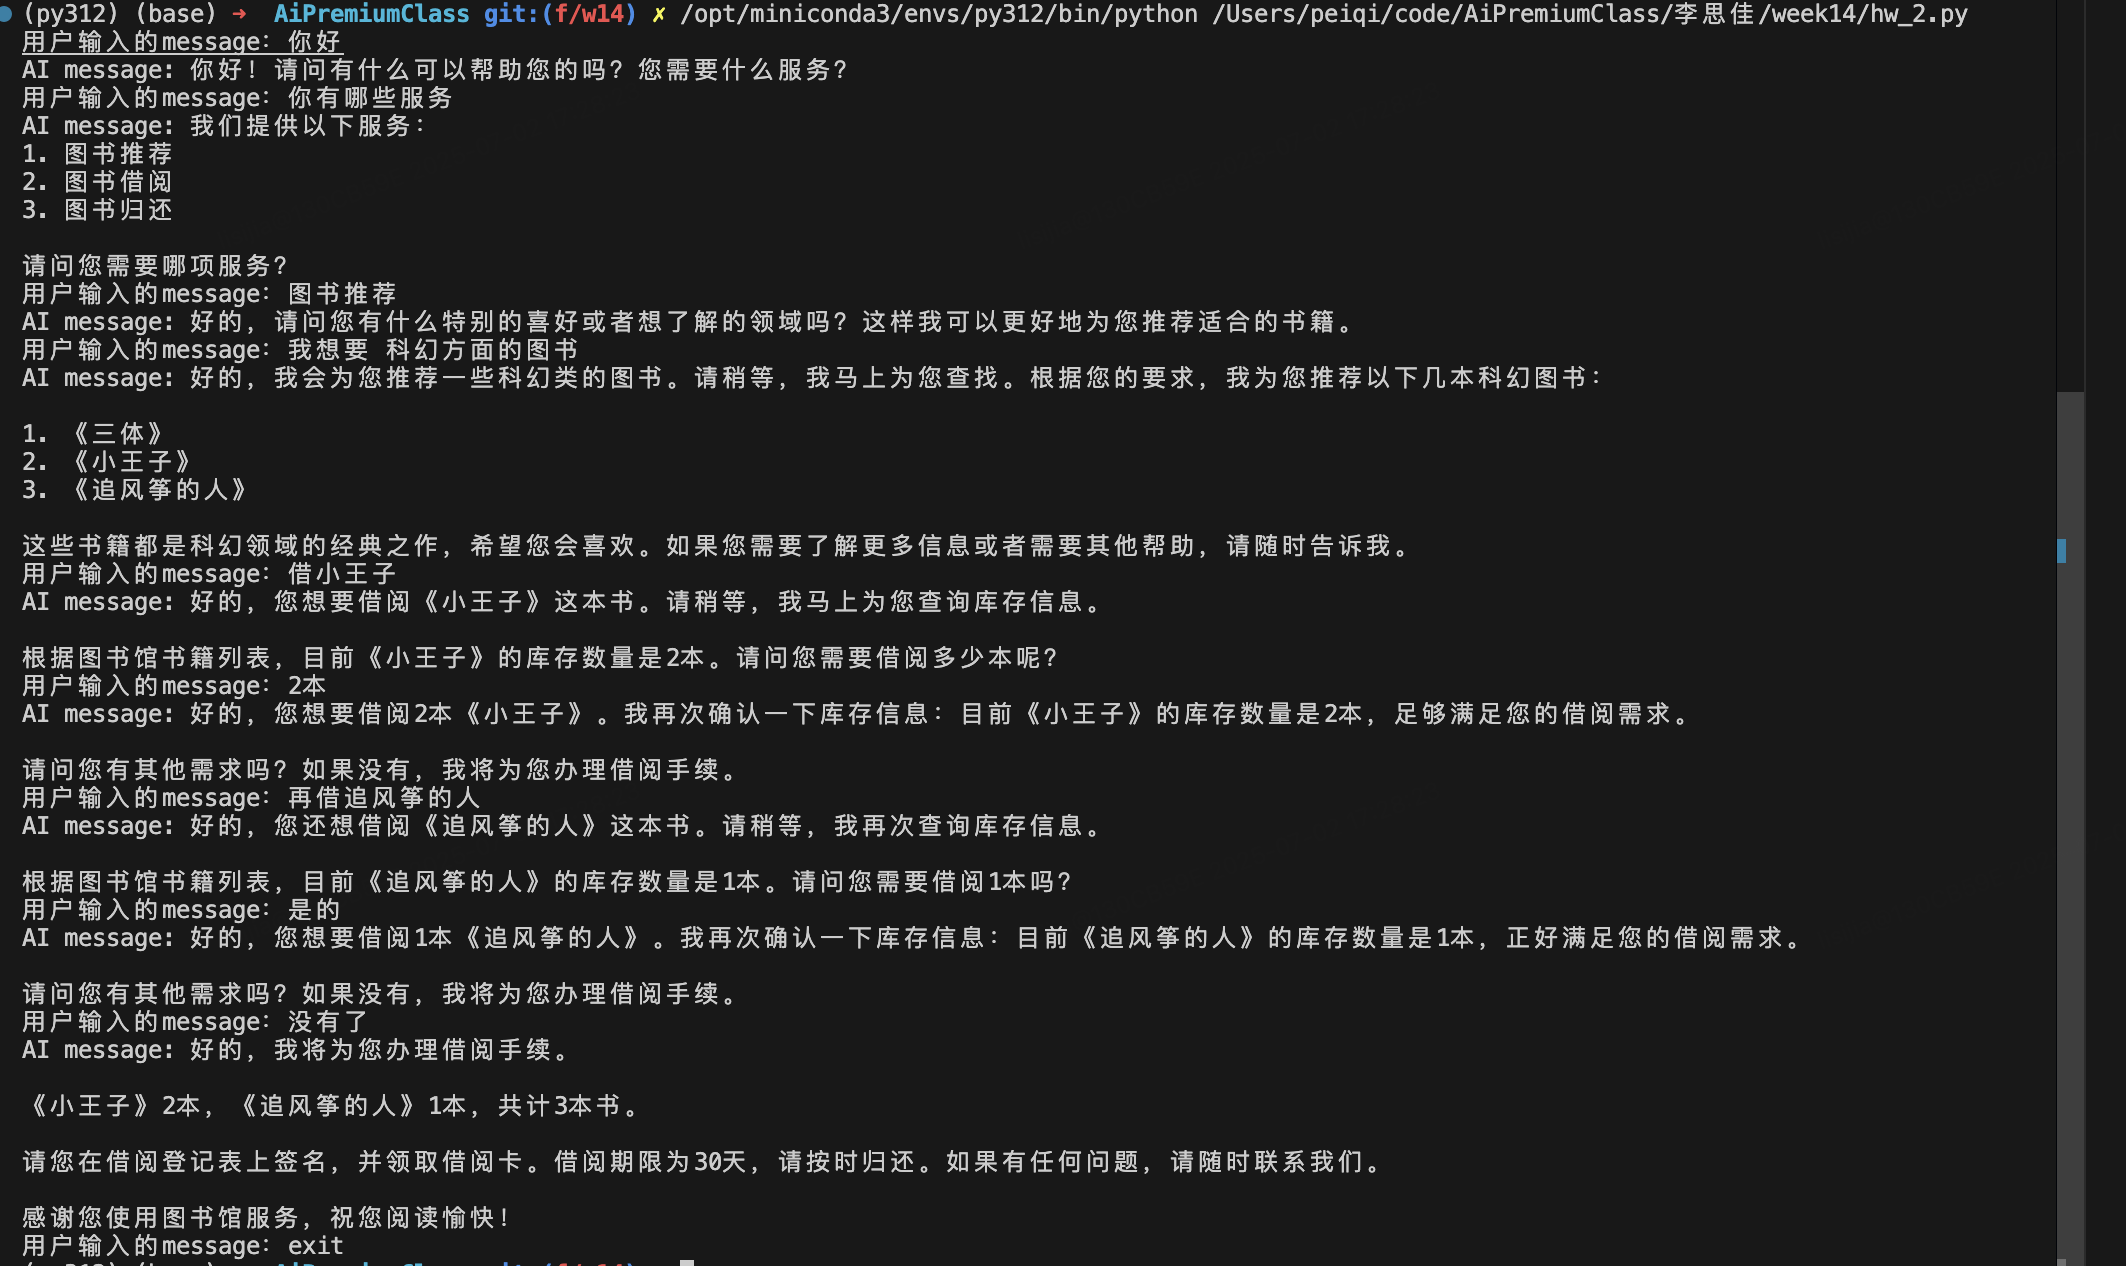